#### I want to manually verify a 100 row sample with BERT

In [1]:
# 07_bert_manual_qa.ipynb
# Set up project root, Python path, and load the processed dataset

from pathlib import Path
import sys
import pandas as pd

# If this notebook lives in notebooks/, go one level up to project root
cwd = Path.cwd().resolve()
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd

print("Project root:", PROJECT_ROOT)

# Make sure src is on the Python path
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.is_dir() and str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# Import config so we reuse the same paths as other notebooks
from config import PROCESSED_DATA_DIR

print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

# Load the processed products_with_splits.parquet
products_path = PROCESSED_DATA_DIR / "products_with_splits.parquet"
df = pd.read_parquet(products_path)

print("Full dataset shape:", df.shape)
print("Splits:")
print(df["split"].value_counts())
print("\nColumns:", df.columns.tolist())

# Peek at a few rows
df[["product_text_raw", "product_text_norm", "label", "split"]].head()

Project root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed
Full dataset shape: (19767, 10)
Splits:
split
train    13961
val       3262
test      2544
Name: count, dtype: int64

Columns: ['event_id', 'event_type', 'start_time_local', 'remove_amazon', 'month', 'product_text_raw', 'product_text_norm', 'label_raw', 'label', 'split']


,product_text_raw,product_text_norm,label,split
0,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0,train
1,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0,train
2,1/2 Ct Diamond Stud Earrings 14k Yellow Gold F...,1 2 ct diamond stud earrings 14k yellow gold f...,1,test
3,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1,train
4,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0,train


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Path to the fine-tuned BERT model we saved earlier
BERT_MODEL_DIR = PROJECT_ROOT / "models" / "bert_fashion"

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_DIR)

# Use MPS if available (on Mac), else CPU – 100 rows is cheap either way
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
model.eval()

print("Loaded BERT model from:", BERT_MODEL_DIR)
print("Using device:", device)

/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded BERT model from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/bert_fashion
Using device: mps


In [3]:
import numpy as np

# 1) Take only the test split (time-held-out)
df_test = df[df["split"] == "test"].copy()
print("Test split size:", len(df_test))

# 2) Sample 100 rows for manual QA (fixed random_state for reproducibility)
qa_sample = df_test.sample(n=100, random_state=42).reset_index(drop=True)

print("QA sample shape:", qa_sample.shape)
qa_sample[["product_text_raw", "product_text_norm", "label"]].head()

Test split size: 2544
QA sample shape: (100, 10)


,product_text_raw,product_text_norm,label
0,3 Pairs 14k Gold Plated Sterling Silver Small ...,3 pairs 14k gold plated sterling silver small ...,1
1,"To My Soulmate Necklace For Women, Funny Gifts...",to my soulmate necklace for women funny gifts ...,1
2,Reebok Boys Underwear Performance Boxer Briefs...,reebok boys underwear performance boxer briefs...,1
3,Nicpro 100 & 250ml Silicone Resin Measuring Cu...,nicpro 100 250ml silicone resin measuring cups...,0
4,Collections Etc Women's Stylish Double-Handle ...,collections etc women s stylish double handle ...,1


In [4]:
# 3) Run BERT on the 100 normalized product names

def bert_predict_proba(texts, batch_size=32):
    all_probs = []

    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start : start + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt",
        )

        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits  # shape [batch, 2]

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        all_probs.append(probs)

    return np.vstack(all_probs)

texts = qa_sample["product_text_norm"].tolist()
probs = bert_predict_proba(texts)

# Probability that the product is fashion (label 1)
qa_sample["bert_prob_fashion"] = probs[:, 1]

# BERT prediction at threshold 0.5 (you can compare to other thresholds later)
qa_sample["bert_pred"] = (qa_sample["bert_prob_fashion"] >= 0.5).astype(int)

# 4) Add empty columns for manual QA
qa_sample["manual_label"] = ""   # you fill this in by hand: 0/1 based on your judgment
qa_sample["notes"] = ""          # optional comments

# 5) Save to CSV for manual review
output_path = PROCESSED_DATA_DIR / "manual_qa_bert_predictions.csv"
cols = [
    "event_id",
    "product_text_raw",
    "product_text_norm",
    "label",               # ground-truth label from our joined dataset
    "bert_prob_fashion",   # model probability for fashion
    "bert_pred",           # model prediction (0/1) at thr=0.5
    "manual_label",        # you will fill
    "notes",               # you will fill
]

qa_sample[cols].to_csv(output_path, index=False)
print("Saved 100-row BERT QA sample to:", output_path)

qa_sample[cols].head()

Saved 100-row BERT QA sample to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_bert_predictions.csv


,event_id,product_text_raw,product_text_norm,label,bert_prob_fashion,bert_pred,manual_label,notes
0,a90daa60d9ad3b92c9b9d4bcb0cb54eb,3 Pairs 14k Gold Plated Sterling Silver Small ...,3 pairs 14k gold plated sterling silver small ...,1,0.999973,1,,
1,15899afe582f907c8516d747129f2091,"To My Soulmate Necklace For Women, Funny Gifts...",to my soulmate necklace for women funny gifts ...,1,0.999975,1,,
2,82a260cd2e7ae91d5fb3ee3e03ed94a1,Reebok Boys Underwear Performance Boxer Briefs...,reebok boys underwear performance boxer briefs...,1,0.999974,1,,
3,9bb2b636af1f0f57002c91137787a395,Nicpro 100 & 250ml Silicone Resin Measuring Cu...,nicpro 100 250ml silicone resin measuring cups...,0,0.000512,0,,
4,2cfa8175573b8627a4213d067b65d6b9,Collections Etc Women's Stylish Double-Handle ...,collections etc women s stylish double handle ...,1,0.999976,1,,


Loaded QA file: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_bert_predictions.csv
Shape before filtering: (100, 8)
Shape after filtering non-empty manual_label: (100, 8)

=== BERT vs manual_label (my labels as ground truth) ===
              precision    recall  f1-score   support

           0     0.6000    0.7059    0.6486        17
           1     0.9375    0.9036    0.9202        83

    accuracy                         0.8700       100
   macro avg     0.7688    0.8047    0.7844       100
weighted avg     0.8801    0.8700    0.8741       100

Confusion matrix (rows=true, cols=pred):
 [[12  5]
 [ 8 75]]


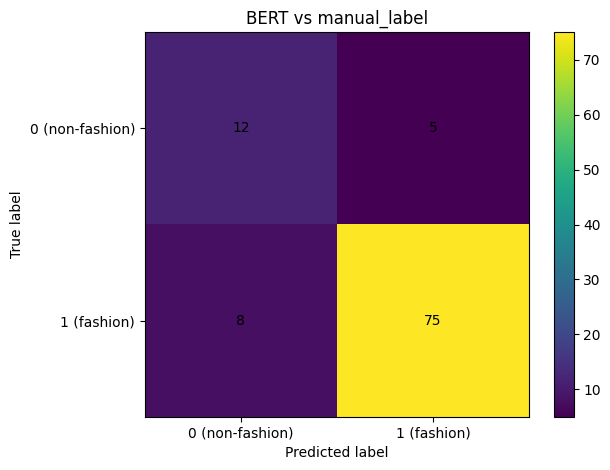


=== BERT vs dataset label (FashionLabels) ===
              precision    recall  f1-score   support

           0     0.8500    0.7391    0.7907        23
           1     0.9250    0.9610    0.9427        77

    accuracy                         0.9100       100
   macro avg     0.8875    0.8501    0.8667       100
weighted avg     0.9078    0.9100    0.9077       100

Confusion matrix (rows=true, cols=pred):
 [[17  6]
 [ 3 74]]


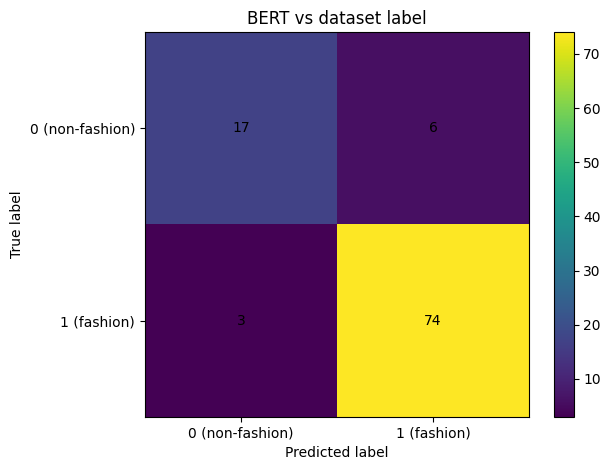


Rows where manual_label != dataset label: 10 out of 100


,product_text_raw,product_text_norm,label_int,manual_label_int,bert_pred_int,bert_prob_fashion
23,"Silicone Resin Measuring Cups Tool Kit, Non-St...",silicone resin measuring cups tool kit non sti...,0,1,0,0.000533
31,"Barbie Doll & Bike Set with Accessories, Blond...",barbie doll bike set with accessories blonde i...,1,0,0,0.003095
42,UBesGoo Portable Closet Organizer Wardrobe Sto...,ubesgoo portable closet organizer wardrobe sto...,0,1,0,0.000556
46,"LET'S RESIN UV Resin,200g Low Viscosity Crysta...",let s resin uv resin 200g low viscosity crysta...,0,1,0,0.000561
51,Magic: The Gathering The Lord of The Rings: Ta...,magic the gathering the lord of the rings tale...,0,1,0,0.000784


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the QA file
qa_path = PROCESSED_DATA_DIR / "manual_qa_bert_predictions.csv"
qa = pd.read_csv(qa_path)

print("Loaded QA file:", qa_path)
print("Shape before filtering:", qa.shape)

# Keep only rows where I actually filled manual_label
qa = qa[qa["manual_label"].astype(str).str.strip() != ""].copy()
print("Shape after filtering non-empty manual_label:", qa.shape)

# Ensure integer labels
qa["manual_label_int"] = qa["manual_label"].astype(int)
qa["label_int"] = qa["label"].astype(int)
qa["bert_pred_int"] = qa["bert_pred"].astype(int)

def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_labels = ["0 (non-fashion)", "1 (fashion)"]
    plt.xticks([0, 1], tick_labels)
    plt.yticks([0, 1], tick_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 1) BERT vs my manual labels
y_true_manual = qa["manual_label_int"].values
y_pred_bert = qa["bert_pred_int"].values

print("\n=== BERT vs manual_label (my labels as ground truth) ===")
print(classification_report(y_true_manual, y_pred_bert, labels=[0, 1], digits=4))
cm_manual = confusion_matrix(y_true_manual, y_pred_bert, labels=[0, 1])
print("Confusion matrix (rows=true, cols=pred):\n", cm_manual)
plot_confusion_matrix(cm_manual, "BERT vs manual_label")

# 2) BERT vs dataset labels
y_true_dataset = qa["label_int"].values

print("\n=== BERT vs dataset label (FashionLabels) ===")
print(classification_report(y_true_dataset, y_pred_bert, labels=[0, 1], digits=4))
cm_dataset = confusion_matrix(y_true_dataset, y_pred_bert, labels=[0, 1])
print("Confusion matrix (rows=true, cols=pred):\n", cm_dataset)
plot_confusion_matrix(cm_dataset, "BERT vs dataset label")

# 3) Optional: how often I disagree with the dataset labels
disagree_mask = qa["manual_label_int"] != qa["label_int"]
print(f"\nRows where manual_label != dataset label: {disagree_mask.sum()} out of {len(qa)}")
qa[disagree_mask][
    ["product_text_raw", "product_text_norm", "label_int", "manual_label_int", "bert_pred_int", "bert_prob_fashion"]
].head()